<p align="right">
  <img
    src="https://drive.google.com/uc?export=view&id=1CzGTq7D3I3CwRf5cfzAgK7H8xK5KNYDk"
    alt="pypl"
    width="300%"
    height="20%">
</p>

# Modulo 5: Portafolios eficientes en Python


## Librerias

In [21]:
!pip install PyPortfolioOpt
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

## Introducción Teórica

### La prima de riesgo

La prima de riesgo se define como la cuantía a la cuál una persona está dispuesta a renunciar de su riqueza a los fines de eliminar el riesgo de su entorno, o desde otro punto de vista más financiero, representa el retorno adicional que los inversores exigen por asumir un riesgo mayor al de un activo libre de riesgo.

$$
\text{Prima de riesgo} = \mathbb{E}(R_i) - R_f
$$

Donde:

- $\mathbb{E}(R_i)$: retorno esperado del activo $i$  
- $R_f$: tasa libre de riesgo (por ejemplo, bonos del Tesoro de EE.UU. o bonos soberanos de alta calidad en moneda local)

Este concepto nos lleva a reconocer que cada individuo tiene una relación diferente con el riesgo, la cual puede representarse mediante curvas de utilidad:

* Las personas más aversas al riesgo requerirán una prima mayor para invertir en activos más volátiles.

* Otras, con mayor tolerancia al riesgo, aceptarán menores recompensas por asumir esa misma volatilidad.

En definitiva, la prima de riesgo refleja no solo condiciones de mercado, sino también comportamientos y preferencias individuales frente a la incertidumbre.



### Teoría de portafolios

La teoría de los portafolios eficientes parte del análisis de un portafolio o cartera con el objetivo de ofrecer un marco matemático para construir portafolios óptimos que maximicen el **retorno esperado dado un nivel de riesgo**, o lo que es igual, **minimicen el riesgo dado un nivel de retorno**. Es decir, busca encontrar la combinación óptima de activos, que mediante la diversificación de los pesos de los mismos en una determinada cartera logren la mejor combinación de riesgo-rentabilidad posible.
Esto se logra, partiendo del concepto de que el riesgo total de un portafolio no es simplemente la suma de los riesgos de los activos individuales, debido a las correlaciones existentes entre ellos. Al combinar activos que no están perfectamente correlacionados, se puede reducir el riesgo total del portafolio sin sacrificar retorno esperado. \
Para la aplicación de este marco, haremos uso de la *media*, la *varianza* y el *coeficiente de correlación*, conceptos vistos en las clases anteriores.



### El caso de un sólo activo


**Precio esperado del activo:**

$$
\mathbb{E}(P) = \sum_{i=1}^n p_i \cdot P_{1,i}
$$

dónde pi representa probabilidad de ocurrencia de un escenario

**Retorno esperado:**

$$
\mathbb{E}(R) = \sum_{i=1}^n p_i \cdot R_i
$$


**Varianza del retorno:**

$$
\text{Var}(R) = \sum_{i=1}^n p_i \cdot (R_i - \mathbb{E}(R))^2
$$

**Desviación estándar del retorno:**

$$
\sigma(R) = \sqrt{\text{Var}(R)}
$$

**Coeficiente de variación:**

$$
CV = \frac{\sigma(R)}{\mathbb{E}(R)}
$$

Suponemos que tenemos un sólo activo, con un precio determinado en el momento t=0. En una fecha futura, este activo puede sufrir modificaciones en su precio dado por distintos escenarios, cada uno con una determinada probabilidad de ocurrencia.

In [22]:
# Precio actual
P0 = 10

# Definimos los estados posibles
data = {
    "Estado": ["Recesión", "Normal", "Expansión"],
    "Precio Futuro": [9, 11, 13],
    "Probabilidad": [0.2, 0.5, 0.3]
}

# Creamos el DataFrame
df = pd.DataFrame(data)

# Calculamos la tasa de retorno
df["Retorno"] = (df["Precio Futuro"] - P0) / P0
df

,Estado,Precio Futuro,Probabilidad,Retorno
0,Recesión,9,0.2,-0.1
1,Normal,11,0.5,0.1
2,Expansión,13,0.3,0.3


En base a a dicha proyección, podemos obtener las medidas descriptivas de dicho activo.

In [23]:
# Precio esperado
precio_esperado = np.sum(df["Precio Futuro"] * df["Probabilidad"])

# Retorno esperado
retorno_esperado = np.sum(df["Retorno"] * df["Probabilidad"])

# Varianza del retorno
varianza_retorno = np.sum(df["Probabilidad"] * (df["Retorno"] - retorno_esperado)**2)

# Desviación estándar
desviacion_retorno = np.sqrt(varianza_retorno)

# Coeficiente de variación
coeficiente_variacion = desviacion_retorno / retorno_esperado #Riesgo por unidad de rendimiento esperado.

# Resultados
print(f"El precio esperado del activo es de: {precio_esperado:.2f}")
print(f"El retorno esperado del activo es de : {retorno_esperado:.2%}")
print(f"La varianza del retorno del activo es de: {varianza_retorno:.4f}")
print(f"La desviación estandar del retorno del activo es de: {desviacion_retorno:.2%}")
print(f"El coeficiente de variación del activo es de: {coeficiente_variacion:.2f}")

El precio esperado del activo es de: 11.20
El retorno esperado del activo es de : 12.00%
La varianza del retorno del activo es de: 0.0196
La desviación estandar del retorno del activo es de: 14.00%
El coeficiente de variación del activo es de: 1.17


### El caso de un portafolio de activos

**Retorno esperado del portafolio:**

$$
\mathbb{E}(R_p) = w_A \cdot \mathbb{E}(R_A) + w_B \cdot \mathbb{E}(R_B)
$$

**Varianza del portafolio (2 activos):**

$$
\text{Var}(R_p) = w_A^2 \cdot \text{Var}(R_A) + w_B^2 \cdot \text{Var}(R_B) + 2 w_A w_B \cdot \text{Cov}(R_A, R_B)
$$

**Covarianza:**

$$
\text{Cov}(R_A, R_B) = \sum p_i \cdot (R_{A,i} - \mathbb{E}(R_A)) \cdot (R_{B,i} - \mathbb{E}(R_B))
$$

**Coeficiente de correlación:**

$$
\rho_{AB} = \frac{\text{Cov}(R_A, R_B)}{\sigma_A \cdot \sigma_B}
$$

**Matriz de varianzas y covarianzas:**

$$
\Sigma =
\begin{bmatrix}
\text{Var}(R_A) & \text{Cov}(R_A, R_B) \\
\text{Cov}(R_A, R_B) & \text{Var}(R_B)
\end{bmatrix}
$$


Ahora, suponemos que tenemos una cartera con dos activos, cada activo con un peso "w" y "1-w" en nuestra cartera de forma tal que [**w + (1-w) = 1**]

In [24]:
#Dataframe con escenarios y activos
df = pd.DataFrame({
    "Estado": ["Recesión", "Normal", "Expansión"],
    "Probabilidad": [0.2, 0.5, 0.3],
    "Rend_A": [-0.10, 0.10, 0.30],
    "Rend_B": [-0.05, 0.08, 0.15],
    "Peso_A": [0.6, 0.60, 0.60],
    "Peso_B": [0.40, 0.40, 0.40]

})

df

,Estado,Probabilidad,Rend_A,Rend_B,Peso_A,Peso_B
0,Recesión,0.2,-0.1,-0.05,0.6,0.4
1,Normal,0.5,0.1,0.08,0.6,0.4
2,Expansión,0.3,0.3,0.15,0.6,0.4


In [25]:
Peso_A = 0.6
Peso_B = 0.4

# Retornos esperados individuales
Rend_A_esperado = np.sum(df["Probabilidad"] * df["Rend_A"])
Rend_B_esperado = np.sum(df["Probabilidad"] * df["Rend_B"])

# Retorno esperado del portafolio
Rend_portfolio_esperado = Peso_A * Rend_A_esperado + Peso_B * Rend_B_esperado

# Desviaciones respecto a la media
df["Desvio_A"] = df["Rend_A"] - Rend_A_esperado
df["Desvio_B"] = df["Rend_B"] - Rend_B_esperado

# Covarianza
covarianza_AB = np.sum(df["Probabilidad"] * df["Desvio_A"] * df["Desvio_B"])

# Varianzas individuales
varianza_A = np.sum(df["Probabilidad"] * df["Desvio_A"]**2)
varianza_B = np.sum(df["Probabilidad"] * df["Desvio_B"]**2)

# Desviaciones estándar
std_A = np.sqrt(varianza_A)
std_B = np.sqrt(varianza_B)

# Correlación
corr_AB = covarianza_AB / (std_A * std_B)

# Varianza del portafolio
varianza_portfolio = (Peso_A**2 * varianza_A) + (Peso_B**2 * varianza_B) + (2 * Peso_A * Peso_B * covarianza_AB)
std_p = np.sqrt(varianza_portfolio)

# Matriz de covarianzas
cov_matrix = np.array([[varianza_A, covarianza_AB],
                       [covarianza_AB, varianza_B]])
cov_df = pd.DataFrame(cov_matrix, index=["A", "B"], columns=["A", "B"])

# Resultados
print(f"Retorno esperado del portafolio: {Rend_portfolio_esperado:.2%}")
print(f"Varianza del portafolio: {varianza_portfolio:.4f}")
print(f"Desviación estándar del portafolio: {std_p:.2%}")
print(f"Covarianza entre A y B: {covarianza_AB:.4f}")
print(f"Correlación entre A y B: {corr_AB:.2f}")
print("\nMatriz de varianzas y covarianzas:")
print(cov_df)

Retorno esperado del portafolio: 10.20%
Varianza del portafolio: 0.0124
Desviación estándar del portafolio: 11.13%
Covarianza entre A y B: 0.0095
Correlación entre A y B: 0.98

Matriz de varianzas y covarianzas:
        A         B
A  0.0196  0.009500
B  0.0095  0.004825


Podemos observar que la varianza en los retornos, en el caso de un portafolio, no es igual a la suma de las varianzas de los retornos de los activos, sino que depende de la covarianza, y por ende, de como se relacionan los dos activos entre sí.\
Ahora, podemos analizar que al fórmula de varianza del portafolio, es la que adquiere mucha importancia a la hora de hablar de portafolios eficientes. Si despejamos la covarianza por medio de la fórmula del coeficiente de correlación, obtenemos lo siguiente:

$$
\text{Var}(R_p) = w_A^2 \cdot \sigma_A^2 + w_B^2 \cdot \sigma_B^2 + 2w_A w_B \cdot \rho_{AB} \cdot \sigma_A \cdot \sigma_B
$$


Y recordando que 𝜌 mide la correlación (la fuerza de la relación, ya sea positiva o negativa entre las variables o activos), podríamos concluir que:

* Si 𝜌 = +1
Los activos se mueven en la misma dirección y con igual proporción.
En este caso, no hay posibilidad de reducir el riesgo mediante diversificación, ya que el portafolio replica perfectamente el comportamiento combinado de ambos activos. Por ende, la relación retorno-riesgo no mejora al combinar activos con correlación +1.

* Si 𝜌 = -1
Los activos se mueven en direcciones opuestas y en igual magnitud.
Esto permite una diversificación perfecta, donde es posible construir un portafolio con varianza (riesgo) igual a cero, si los pesos se eligen adecuadamente.Es el caso ideal para maximizar la relación retorno-riesgo.

* Si -1 < 𝜌 < 1
Los activos no se mueven ni perfectamente en la misma dirección ni perfectamente en direcciones opuestas.Esto representa la mayoría de los casos reales. En estos casos, la diversificación sigue siendo efectiva, permitiendo reducir el riesgo total del portafolio sin sacrificar retorno esperado. Cuanto más baja la correlación (más cercana a cero o negativa), mayor el beneficio en términos de diversificación.

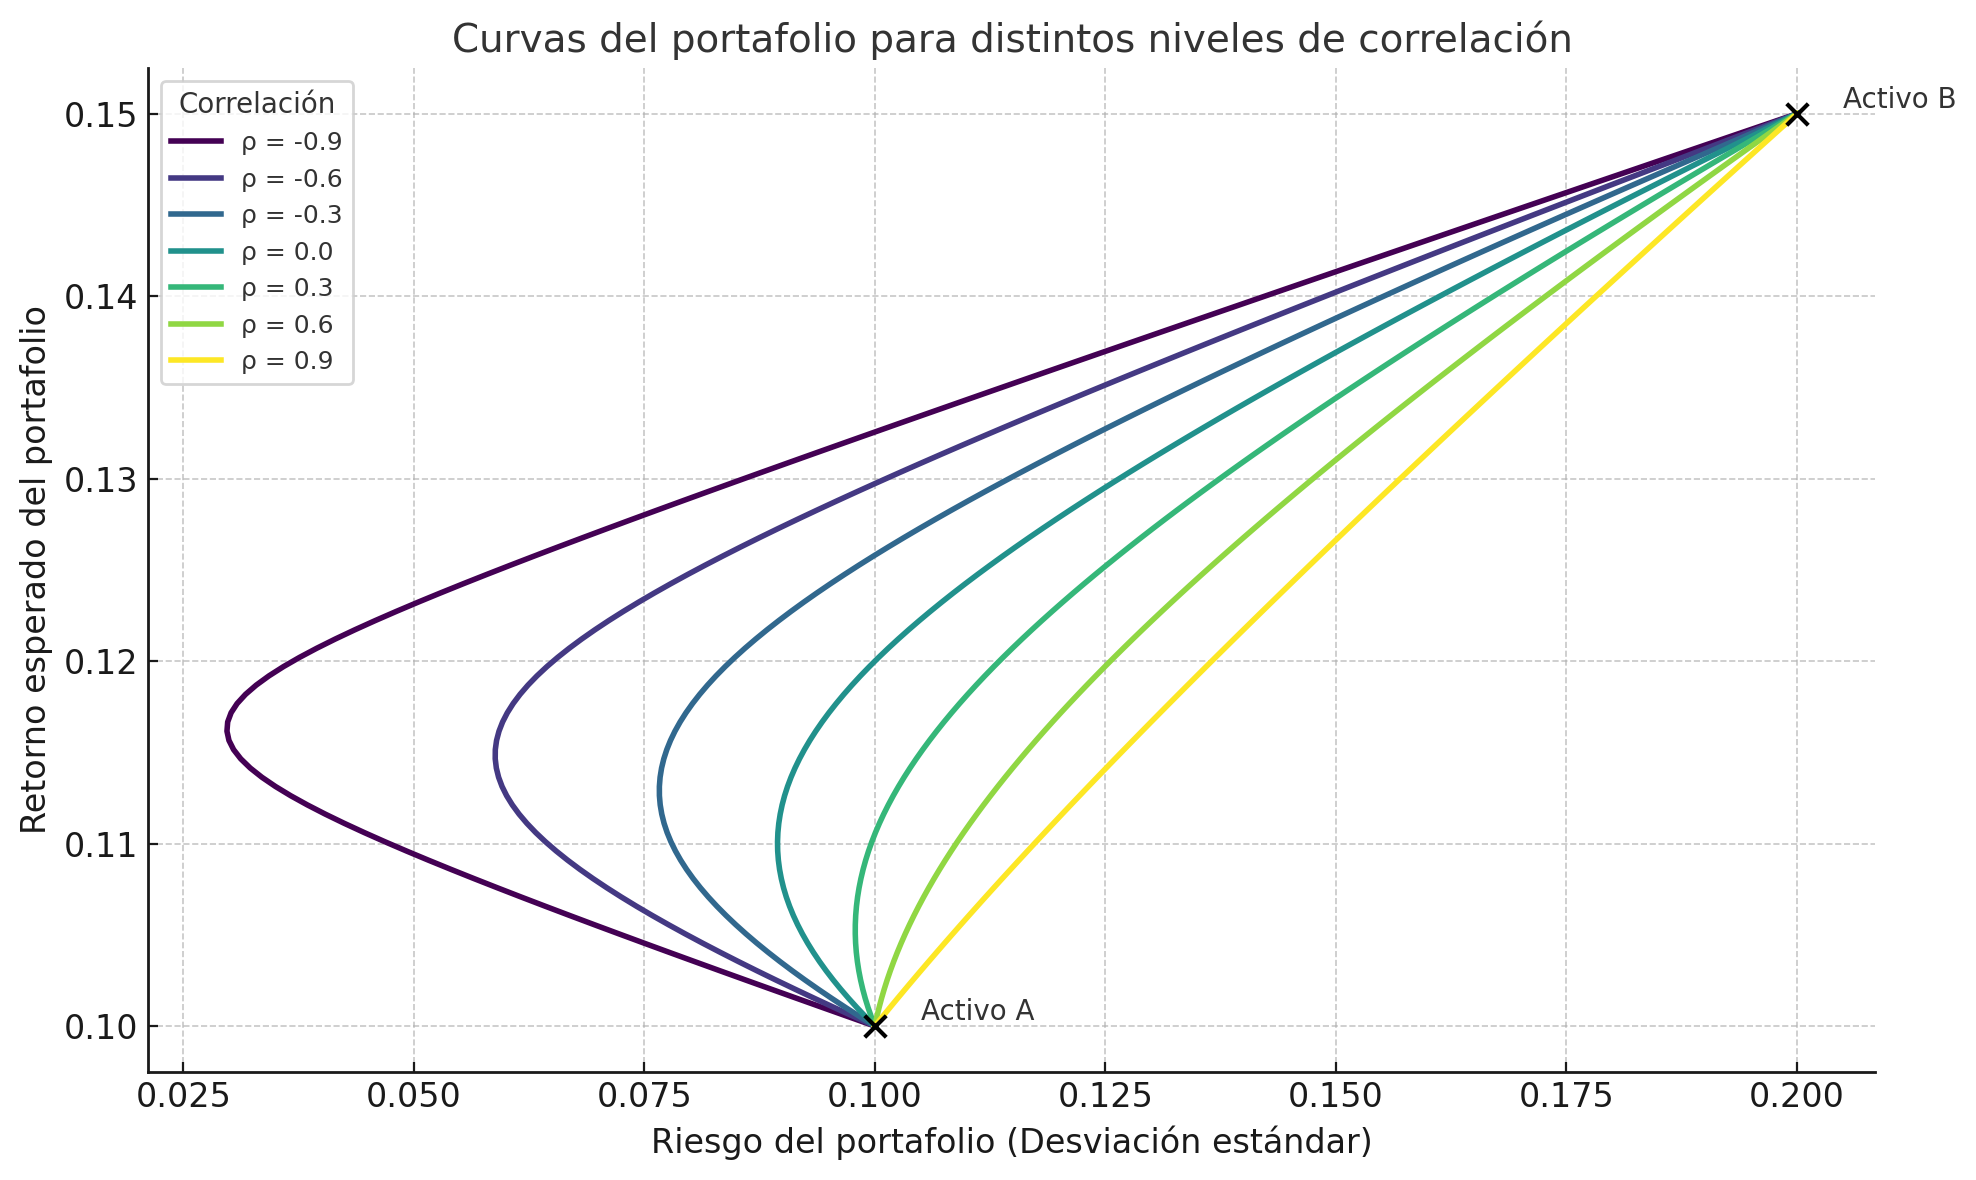

Operando entonces con las funciones de rendimiento esperado del portafolio y varianza, es posible llegar a los ponderadores óptimos (w y 1-w) que hagan que la cartera sea eficiente en términos de maximizar el rendimiento dado un nivel de riesgo.

## Ejemplo - maximización del Ratio Sharpe

Vamos a utilizar la librería Yahoo Finance para obtener cotizaciones reales de activos y aplicar la teoría de carteras eficientes.

In [26]:
# Seleccionaamos los activos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']
start_date = '2020-01-01'
end_date = '2024-12-31'

# Descarga de datos de cierre ajustado
data = yf.download(tickers, start=start_date, end=end_date)['Close']
data = data.dropna()

# Cálculo de retornos diarios
returns = data.pct_change().dropna()
returns.head()


/tmp/ipython-input-26-2784592127.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,GOOGL,MSFT,TSLA
Date,,,,
2020-01-03,-0.009722,-0.005232,-0.012452,0.029633
2020-01-06,0.007968,0.026654,0.002585,0.019255
2020-01-07,-0.004703,-0.001932,-0.009118,0.038801
2020-01-08,0.016086,0.007118,0.015929,0.049205
2020-01-09,0.021241,0.010498,0.012493,-0.021945


Calculamos de forma anual la media de los retornos diarios y la matriz de varianzas y covarianzas de los retornos

In [27]:
# Retornos anuales y matriz de covarianza anualizada
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

mean_returns, cov_matrix


(Ticker
 AAPL     0.299545
 GOOGL    0.259848
 MSFT     0.250702
 TSLA     0.762471
 dtype: float64,
 Ticker      AAPL     GOOGL      MSFT      TSLA
 Ticker                                        
 AAPL    0.100420  0.066844  0.072340  0.102752
 GOOGL   0.066844  0.105677  0.073995  0.087143
 MSFT    0.072340  0.073995  0.093067  0.091489
 TSLA    0.102752  0.087143  0.091489  0.451442)

Obtenida la media de los retornos y la matriz de varianza y covarianza, armamos algunas funciones que serán de utilidad para trabajar:

In [28]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    retorno = np.dot(weights, mean_returns)  #Hacemos el producto entre retornos medios (esperados) y los pesos para obtener el retorno esperado del portafolio
    volatilidad = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) #Calculamos la volatilidad del portafolio mediante la desviación estándar.
    return retorno, volatilidad

def negative_sharpe(weights, mean_returns, cov_matrix, rf=0.01):
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix) #Calculamos el ratio de Sharpe
    return -(ret - rf) / vol

def check_sum(weights):
    return np.sum(weights) - 1  #CHequeamos que la suma de los pesos sea = 1


Con estas funciones, podemos obtener la cartera que maximiza el Ratio de Sharpe. Recordando que:

$$
\text{Sharpe Ratio} = \frac{E(R_p) - R_f}{\sigma_p}
$$

esta cartera será aquella que me maximice mediante la diversificación, la relación rendimiento-riesgo, ajustando por la tasa libre de riesgo. Cabe resaltar, que será un punto dentro de la frontera eficiente de carteras mencionada.

In [29]:
num_assets = len(tickers) #Traemos los tickers
print(num_assets)
init_guess = [1/num_assets] * num_assets  #Peso inicial igualitario para cada activo
print(init_guess)
bounds = tuple((0, 1) for _ in range(num_assets)) #limites para los pesos, entre 0 y 1
print(bounds)
constraints = {'type': 'eq', 'fun': check_sum} #Defino que la suma de los pesos debe dar 1.
print(constraints)

opt_result = minimize(negative_sharpe, init_guess,
                      args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints) #Armamos el algoritmo que minimiza el ratio sharpe negativo y esto nos da los pesos

opt_weights = opt_result.x
print(opt_weights)
opt_return, opt_risk = portfolio_performance(opt_weights, mean_returns, cov_matrix)
opt_sharpe = (opt_return - 0.01) / opt_risk

print("Pesos óptimos:", dict(zip(tickers, np.round(opt_weights, 4))))
print("El retorno esperado del portafolio es:", round(opt_return, 4))
print("El riesgo esperado del portafolio es:", round(opt_risk, 4))
print("Sharpe ratio:", round(opt_sharpe, 4))


4
[0.25, 0.25, 0.25, 0.25]
((0, 1), (0, 1), (0, 1), (0, 1))
{'type': 'eq', 'fun': <function check_sum at 0x7c22869518a0>}
[3.97802041e-01 1.77565047e-01 1.85398571e-17 4.24632912e-01]
Pesos óptimos: {'AAPL': np.float64(0.3978), 'MSFT': np.float64(0.1776), 'GOOGL': np.float64(0.0), 'TSLA': np.float64(0.4246)}
El retorno esperado del portafolio es: 0.4891
El riesgo esperado del portafolio es: 0.3974
Sharpe ratio: 1.2055


**Conclusiones del Portafolio Optimizado**\

🎯 Asignación óptima de activos:

39.8% en Apple (AAPL)

17.8% en Microsoft (MSFT)

42.5% en Tesla (TSLA)

0% en Google (GOOGL)

💰 Retorno esperado: \

El portafolio proyecta un rendimiento del 48.9% en el periodo analizado.

⚖️ Riesgo (Volatilidad): \

La volatilidad es alta, aproximadamente 39.7%, indicando fluctuaciones importantes en el retorno.

🚀 Sharpe Ratio: \

Un valor de 1.21, implica que la cartera está ofreciendo 1.21 unidades de retorno por cada unidad de riesgo asumido.

## Ejemplo - frontera eficiente

Para calcular la frontera eficiente con nuestros datos, en primer lugar vamos a encontrar el retorno máximo eficiente y mínimo eficiente, maximizando y minimizando el retorno esperado de la cartera, similar al algoritmo empleado antes.

In [30]:
# Retorno mínimo (minimizar retorno)
min_return_result = minimize(
    lambda w: np.dot(w, mean_returns), #Producto punto de los pesos por la media de los retornos.
    init_guess,
    method='SLSQP',
    bounds=bounds,
    constraints={'type': 'eq', 'fun': check_sum}
)

min_return = min_return_result.fun if min_return_result.success else None

# Retorno máximo (maximizar retorno -> minimizar negativo)
max_return_result = minimize(
    lambda w: -np.dot(w, mean_returns), #Producto punto de los pesos por la media de los retornos, en negativo para obtener el máximo.
    init_guess,
    method='SLSQP',
    bounds=bounds,
    constraints={'type': 'eq', 'fun': check_sum}
)

max_return = -max_return_result.fun if max_return_result.success else None

print(f"Retorno mínimo factible: {min_return}")
print(f"Retorno máximo factible: {max_return}")


Retorno mínimo factible: 0.250701736999202
Retorno máximo factible: 0.7624713732542109


Luego, usamos esos targets para obtener en el medio, todas las combinaciones riesgo-retorno y así graficar la curva.

[0.25       0.25515152 0.26030303 0.26545455 0.27060606 0.27575758
 0.28090909 0.28606061 0.29121212 0.29636364 0.30151515 0.30666667
 0.31181818 0.3169697  0.32212121 0.32727273 0.33242424 0.33757576
 0.34272727 0.34787879 0.3530303  0.35818182 0.36333333 0.36848485
 0.37363636 0.37878788 0.38393939 0.38909091 0.39424242 0.39939394
 0.40454545 0.40969697 0.41484848 0.42       0.42515152 0.43030303
 0.43545455 0.44060606 0.44575758 0.45090909 0.45606061 0.46121212
 0.46636364 0.47151515 0.47666667 0.48181818 0.4869697  0.49212121
 0.49727273 0.50242424 0.50757576 0.51272727 0.51787879 0.5230303
 0.52818182 0.53333333 0.53848485 0.54363636 0.54878788 0.55393939
 0.55909091 0.56424242 0.56939394 0.57454545 0.57969697 0.58484848
 0.59       0.59515152 0.60030303 0.60545455 0.61060606 0.61575758
 0.62090909 0.62606061 0.63121212 0.63636364 0.64151515 0.64666667
 0.65181818 0.6569697  0.66212121 0.66727273 0.67242424 0.67757576
 0.68272727 0.68787879 0.6930303  0.69818182 0.70333333 0.70848

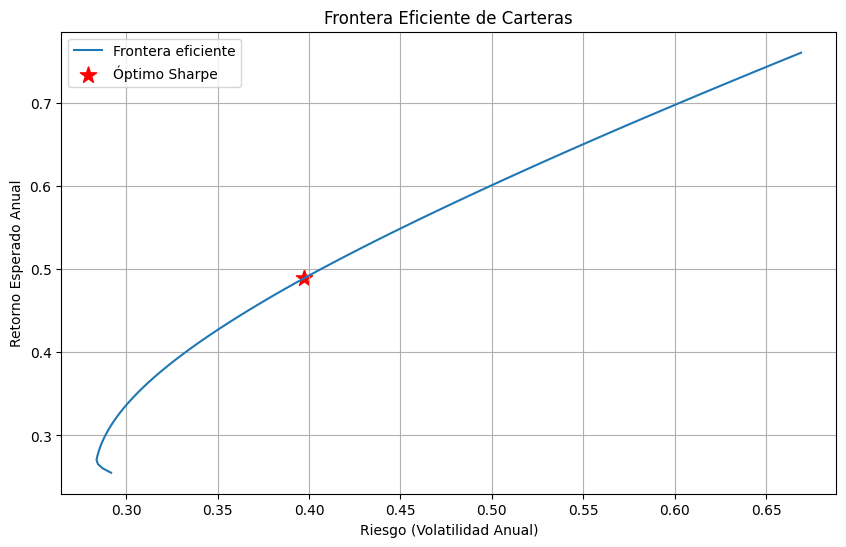

In [31]:
target_returns = np.linspace(0.25, 0.76, 100) # EL 100 da los puntos que agregamos entre una iteración y la otra.
print(target_returns)
efficient_risks = []
valid_returns = []

for target in target_returns:
    constraints = (
        {'type': 'eq', 'fun': check_sum},
        {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target}
    )
    result = minimize(
        lambda w: portfolio_performance(w, mean_returns, cov_matrix)[1],
        init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    if result.success:
        efficient_risks.append(result.fun)
        valid_returns.append(target)
        print(f"Converge para retorno objetivo {target:.4f}")
    else:
        print(f"No converge para retorno objetivo {target:.4f}")

# Graficamos solo puntos válidos
plt.figure(figsize=(10, 6))
plt.plot(efficient_risks, valid_returns, label='Frontera eficiente')
plt.scatter(opt_risk, opt_return, c='red', marker='*', s=150, label='Óptimo Sharpe') #Graficamos el resultado de maximizar el ratio de sharpe.
plt.xlabel('Riesgo (Volatilidad Anual)')
plt.ylabel('Retorno Esperado Anual')
plt.title('Frontera Eficiente de Carteras')
plt.legend()
plt.grid(True)
plt.show()



## Ejemplo - Frontera eficiente - Sharpe, Sortino y Treynor

En este caso, hacemos uso de la libreria de optimización **pyportfolioopt**. De forma similar, traemos la info del dataset inicial:

In [32]:
# Retornos esperados y matriz de covarianza anual
retorno_esperado = expected_returns.mean_historical_return(data) #traemos los retornos esperados y la matriz de covarianza anual, utilizando los métodos propios de la libreria.
matriz = risk_models.sample_cov(data)
print(retorno_esperado)
print(matriz)

Ticker
AAPL     0.283132
GOOGL    0.229875
MSFT     0.226391
TSLA     0.711297
dtype: float64
Ticker      AAPL     GOOGL      MSFT      TSLA
Ticker                                        
AAPL    0.100420  0.066844  0.072340  0.102752
GOOGL   0.066844  0.105677  0.073995  0.087143
MSFT    0.072340  0.073995  0.093067  0.091489
TSLA    0.102752  0.087143  0.091489  0.451442


Calculamos mediante los propios métodos de la libreria, el máximo del ratio sharpe

In [33]:
#Calculamos el portafolio óptimo según Sharpe
ef = EfficientFrontier(retorno_esperado, matriz)
weights_opt = ef.max_sharpe(risk_free_rate=0.01)
cleaned_weights = ef.clean_weights()

print("\nPesos óptimos (Sharpe max):")
print(cleaned_weights)
ef.portfolio_performance(verbose=True)


Pesos óptimos (Sharpe max):
OrderedDict([('AAPL', 0.47506), ('GOOGL', 0.09118), ('MSFT', 0.0), ('TSLA', 0.43376)])
Expected annual return: 46.4%
Annual volatility: 40.4%
Sharpe Ratio: 1.12


/usr/local/lib/python3.11/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(np.float64(0.4639969326718171),
 np.float64(0.4043638866016967),
 np.float64(1.1227435181891243))

Por otra parte, calculamos los indicadores de la cartera equiponderada, es decir, en la cuál todos los activos tienen el mismo peso.

In [34]:
# Portafolio equiponderado(el cuál tiene igual peso en todos los activos, 0.25)
equal_weights = np.array([1/len(tickers)] * len(tickers))
ret_eq = np.dot(equal_weights, retorno_esperado)
risk_eq = np.sqrt(equal_weights.T @ matriz.values @ equal_weights)
sharpe_eq = (ret_eq - 0.01) / risk_eq

print(f'El retorno esperado es del {ret_eq:.4f}')
print(f'La volatilidad esperada es de {risk_eq:.4f}')
print(f'El Ratio Sharpe es de {sharpe_eq:.4f}')

El retorno esperado es del 0.3627
La volatilidad esperada es de 0.3297
El Ratio Sharpe es de 1.0695


Ahora, para obtener el Ratio Treynor, debemos obtener el Beta respecto a un índice. En este caso, consideramos el S&P500

In [35]:
# Bajamos los datos de mercado (benchmark) - S&P 500
market_data = yf.download("^GSPC", start=start_date, end=end_date)['Close'].dropna()

#Obtenemos los datos de variaciones diarias.
returns_daily = data.pct_change().dropna()
market_returns_daily = market_data.pct_change().dropna()

/tmp/ipython-input-35-2696889708.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_data = yf.download("^GSPC", start=start_date, end=end_date)['Close'].dropna()
[*********************100%***********************]  1 of 1 completed


Luego, calculamos el bete entre los retornos diarios de las acciones y el retorno diario del SP500, mediante la matriz de covarianzas.

In [36]:
def calculate_beta(portfolio_returns, market_returns):
    common_idx = portfolio_returns.index.intersection(market_returns.index)
    port_aligned = portfolio_returns.loc[common_idx] #Mismas fechas
    mkt_aligned = market_returns.loc[common_idx] #Mismas fechas
    # Convertirmos a un array
    port_arr = port_aligned.to_numpy().flatten()
    print(port_arr)
    mkt_arr = mkt_aligned.to_numpy().flatten()
    print(mkt_arr)
    #Calculamos el beta por medio de la matriz de covarianza, recordando que beta = Cov(Rp,Rm)/V(Rm)
    cov = np.cov(port_arr, mkt_arr)
    print(f'La matriz de var y cov es {cov}')
    beta = cov[0, 1] / cov[1, 1]
    return beta

Traemos los pesos y traemos los retornos, por un lado optimos y por otro lado los equiponderados.

In [37]:
# Portafolio óptimo retornos diarios
weights_opt_array = np.array([cleaned_weights[t] for t in tickers])
portfolio_opt_returns = returns_daily.dot(weights_opt_array)

# Portafolio equiponderado retornos diarios
portfolio_eq_returns = returns_daily.dot(equal_weights)

Por último, calculamos el beta, de ambos portafolios.

In [38]:
# Calculamos betas
beta_opt = calculate_beta(portfolio_opt_returns, market_returns_daily)
beta_eq = calculate_beta(portfolio_eq_returns, market_returns_daily)

[ 0.00709974  0.01237299  0.01376456 ... -0.00639174 -0.0293305
 -0.02182745]
[-0.00705987  0.00353337 -0.00280324 ... -0.00040566 -0.01105574
 -0.010702  ]
La matriz de var y cov es [[0.00065169 0.00024387]
 [0.00024387 0.00018084]]
[ 0.00055688  0.0141155   0.00576199 ... -0.00495795 -0.02363562
 -0.01685014]
[-0.00705987  0.00353337 -0.00280324 ... -0.00040566 -0.01105574
 -0.010702  ]
La matriz de var y cov es [[0.00043148 0.00022863]
 [0.00022863 0.00018084]]


Luego, para calcular el ratio de sortino, lo que debemos hacer calcular la desviación estándar de los desvíos negativos.

In [39]:
risk_free_rate = 0.01
risk_free_rate_daily = risk_free_rate / 252

def downside_deviation(returns, mar):  #Considera sólo los dias negativos, en los cuales el retorno fue menor a la tasa diaria de RF.
    downside = returns[returns < mar]
    if len(downside) == 0:
        return 0.0
    return np.sqrt(np.mean((downside - mar)**2)) * np.sqrt(252)

dd_opt = downside_deviation(portfolio_opt_returns, risk_free_rate_daily)
dd_eq = downside_deviation(portfolio_eq_returns, risk_free_rate_daily)

Y finalmente hacemos una comparación de los 3 ratios empleados, en los 2 portafolios, el equiponderado y el óptimo.

In [40]:
# Retornos anuales portafolios
ret_opt_annual = portfolio_opt_returns.mean() * 252
ret_eq_annual = portfolio_eq_returns.mean() * 252

# Volatilidades anuales portafolios
vol_opt_annual = portfolio_opt_returns.std() * np.sqrt(252)
vol_eq_annual = portfolio_eq_returns.std() * np.sqrt(252)

# Ratios para portafolio óptimo
sharpe_opt = (ret_opt_annual - risk_free_rate) / vol_opt_annual
treynor_opt = (ret_opt_annual - risk_free_rate) / beta_opt if beta_opt != 0 else np.nan
sortino_opt = (ret_opt_annual - risk_free_rate) / dd_opt if dd_opt != 0 else np.nan

# Ratios para portafolio equiponderado
sharpe_eq = (ret_eq_annual - risk_free_rate) / vol_eq_annual
treynor_eq = (ret_eq_annual - risk_free_rate) / beta_eq if beta_eq != 0 else np.nan
sortino_eq = (ret_eq_annual - risk_free_rate) / dd_eq if dd_eq != 0 else np.nan

# Comparativo
df_comparison = pd.DataFrame({
    'Retorno esperado': [ret_opt_annual, ret_eq_annual],
    'Riesgo esperado': [vol_opt_annual, vol_eq_annual],
    'Beta': [beta_opt, beta_eq],
    'Sharpe Ratio': [sharpe_opt, sharpe_eq],
    'Treynor Ratio': [treynor_opt, treynor_eq],
    'Sortino Ratio': [sortino_opt, sortino_eq]
}, index=['Portafolio Óptimo', 'Portafolio Equiponderado'])

print("\nComparación de métricas de desempeño:")
print(df_comparison.round(4))



Comparación de métricas de desempeño:
                          Retorno esperado  Riesgo esperado    Beta  \
Portafolio Óptimo                   0.4959           0.4052  1.3486   
Portafolio Equiponderado            0.3931           0.3297  1.2643   

                          Sharpe Ratio  Treynor Ratio  Sortino Ratio  
Portafolio Óptimo               1.1990         0.3603         1.2022  
Portafolio Equiponderado        1.1619         0.3030         1.1237  


**Conclusiones del análisis comparativo de desempeño entre el Portafolio Óptimo y el Portafolio Equiponderado**

1. Retorno Esperado \

  Portafolio Óptimo: 49.6%\
  Equiponderado: 39.3%

📈 El portafolio optimizado logra un retorno esperado superior en +10.3 puntos porcentuales, gracias a una asignación eficiente de pesos basada en el ratio de Sharpe.

2. Riesgo (Volatilidad Anual)\

  Portafolio Óptimo: 40.5% \
  Equiponderado: 32.97%

⚠️ El mayor retorno del portafolio óptimo viene acompañado de mayor riesgo (volatilidad). Sin embargo, este riesgo adicional está justificado por una mejor compensación en los ratios de desempeño.

3. Beta (Riesgo Sistémico) \

  Óptimo: 1.35 \
  Equiponderado: 1.26

💡 Ambos portafolios son más volátiles que el mercado (beta > 1), pero el portafolio óptimo está algo más expuesto al riesgo sistemático.

4. Ratio de Sharpe \

  Óptimo: 1.199 \
  Equiponderado: 1.162

✅ El portafolio óptimo presenta una mejor relación retorno/riesgo total. Aunque la diferencia no es enorme, muestra una optimización eficiente en términos de rentabilidad ajustada por volatilidad.

5. Ratio de Treynor \

  Óptimo: 0.360 \
  Equiponderado: 0.303

📌 El portafolio optimizado también tiene una mejor rentabilidad ajustada por el riesgo sistemático. Esto indica una mejor gestión de la exposición al mercado.

6. Ratio de Sortino \

  Óptimo: 1.202 \
  Equiponderado: 1.124

🧠 El portafolio optimizado no solo controla mejor el riesgo total, sino que también es más eficiente en limitar la volatilidad negativa, lo cual es especialmente relevante para inversores más adversos al riesgo.